## GMM estimation of Lucas Tree Model

In [1]:
import numpy as np
from fredapi import Fred
import pandas as pd


fred = Fred(api_key='81d6202762edfdf9248639fbd6972c39')

C = (fred.get_series('PCECC96'))
R = fred.get_series('WILL5000INDFC')
Rf = fred.get_series('TB3MS')
Deflator = fred.get_series('GDPDEF')






#Computing quarterly observations for stock returns and Treasuries

In [2]:
import datetime
# Downsample to quarterly frequency
Rq = R.resample('Q', how='mean', fill_method='bfill') 
Rfq = Rf.resample('Q', how='mean', fill_method='bfill') 

# Shift dates
Rq = Rq.shift(1, freq='D')
Rfq = Rfq.shift(1, freq='D')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().bfill()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().bfill()
  after removing the cwd from sys.path.


In [3]:
data = pd.DataFrame()
data.insert(0,"Consumption", C)
data.insert(1, "Returns", Rq)
data.insert(2, "Tbill", Rfq)
data.insert(3, "Deflator", Deflator)
print(data)

            Consumption     Returns     Tbill  Deflator
1947-01-01     1274.952         NaN  0.380000    11.960
1947-04-01     1296.163         NaN  0.380000    12.131
1947-07-01     1300.388         NaN  0.380000    12.335
1947-10-01     1300.801         NaN  0.736667    12.639
1948-01-01     1307.283         NaN  0.906667    12.739
1948-04-01     1322.494         NaN  0.990000    12.854
1948-07-01     1324.446         NaN  1.000000    13.092
1948-10-01     1335.016         NaN  1.050000    13.132
1949-01-01     1337.177         NaN  1.140000    13.062
1949-04-01     1357.672         NaN  1.170000    12.931
1949-07-01     1360.751         NaN  1.170000    12.872
1949-10-01     1380.702         NaN  1.043333    12.873
1950-01-01     1403.690         NaN  1.076667    12.853
1950-04-01     1426.807         NaN  1.103333    12.897
1950-07-01     1500.076         NaN  1.153333    13.177
1950-10-01     1454.855         NaN  1.220000    13.425
1951-01-01     1490.034         NaN  1.336667   

In [4]:
data.insert(4, "Real Returns", \
            (1 + data['Returns'].pct_change())/ \
            (1 + data['Deflator'].pct_change()) )

In [5]:
data.insert(4, "Real Tbill", \
            (1 + data['Tbill'].pct_change())/ \
            (1 + data['Deflator'].pct_change()) )

In [6]:
Dataset = data.dropna('index')


In [7]:
print(Dataset)

            Consumption     Returns     Tbill  Deflator  Real Tbill  \
1971-04-01     3185.993    1.080000  3.840000    22.685    0.708014   
1971-07-01     3211.394    1.136667  4.250000    22.916    1.095614   
1971-10-01     3264.679    1.113333  5.010000    23.107    1.169079   
1972-01-01     3307.767    1.113333  4.230000    23.458    0.831678   
1972-04-01     3370.736    1.240000  3.436667    23.604    0.807425   
1972-07-01     3422.682    1.280000  3.770000    23.830    1.086589   
1972-10-01     3503.001    1.293333  4.220000    24.134    1.105264   
1973-01-01     3566.957    1.356667  4.863333    24.412    1.139325   
1973-04-01     3565.349    1.306667  5.700000    24.787    1.154304   
1973-07-01     3577.898    1.196667  6.603333    25.270    1.136337   
1973-10-01     3567.227    1.243333  8.323333    25.773    1.235874   
1974-01-01     3535.312    1.176667  7.500000    26.260    0.884370   
1974-04-01     3548.041    1.130000  7.616667    26.880    0.992131   
1974-0

In [8]:
# Compute the stochastic discount factor 
β = 0.99

def SDF(γ, Dataset):
    M = β*(1 + Dataset.Consumption.pct_change())**(-γ)
    return M

def EulerError(γ, Dataset):
    EM  = np.mean(SDF(γ, Dataset))

    ER  = np.mean(Dataset['Real Returns'])

    R = np.array(Dataset['Real Returns'])
    M = np.array(SDF(γ,Dataset))
    extract = pd.DataFrame()
    extract.insert(0,"R", R)
    extract.insert(0,"M", M)

    covar = extract.cov()

    error = 1 - covar['M'][1] - EM*ER
    print(error)
    return error


t = EulerError(0.5,Dataset)


-0.005219170729688027


In [9]:
from scipy.optimize import root

result = root(EulerError,0.779, args=(Dataset))
print(result.x)

-0.0031149101829823778
-0.0031149101829823778
-0.0031149101829823778
-0.003114910095589174
-8.195673208089005e-06
-2.167997870117233e-08
-1.5187850976872141e-13
2.220446049250313e-16
[1.19383238]


to determine the pertinence of this estimate, I would perform a lab experiment.

### question 3

In [10]:
β = 0.99

def EulerError2(γ, Dataset):
    EM  = np.mean(SDF(γ, Dataset))

    ERf  = np.mean(Dataset['Real Tbill'])

    error = (ERf)*EM - 1
    print(error)
    return error

EulerError2(0.5, Dataset)

0.018665568762408435


0.018665568762408435

In [11]:
from scipy.optimize import root
EulerError2_x = lambda x: EulerError2(x,Dataset)
result = root(EulerError2,0.6, args = Dataset)
print(result.x)

0.017912307064960054
0.017912307064960054
0.017912307064960054
0.01791230699765678
0.0002718684811815475
4.216414595026308e-06
1.0146481432826704e-09
4.6629367034256575e-15
-1.1102230246251565e-16
[3.01675539]


The result is similar based on this equation but the estimate is more sensitive to initial conditions.

In [26]:

def SDF_GMM(γ, β, Dataset):
    M = β*(1 + Dataset.Consumption.pct_change())**(-γ)
    return M

def GMM(X, Dataset):
    γ, β = X
    EM  = np.mean(SDF_GMM(γ, β, Dataset))

    ER  = np.mean(Dataset['Real Returns'])

    R = np.array(Dataset['Real Returns'])
    M = np.array(SDF_GMM(γ, β, Dataset))
    extract = pd.DataFrame()
    extract.insert(0,"R", R)
    extract.insert(0,"M", M)

    covar = extract.cov()

    error1 = 1 - covar['M'][1] - EM*ER
    
    #Second equation
    ERf  = np.mean(Dataset['Real Tbill'])
    error2 = ERf*EM - 1
    error = [error1, error2]
#     print(error)
    return error

GMM([0.5,0.99], Dataset)

[-0.005219170729688027, 0.0189240889245208]

In [27]:
from scipy.optimize import broyden1
GMM_x = lambda x: GMM(x,Dataset)
result = root(GMM,[3,0.6], args = Dataset)
print(result.x)

[-1.84445291e+02  1.36678340e-01]


In [20]:

βgrid = np.linspace(0,1,25)
γgrid = np.linspace(0,5,25)

X,Y = np.meshgrid(βgrid,γgrid)

def GMM(γ, β, Dataset):

    EM  = np.mean(SDF_GMM(γ, β, Dataset))

    ER  = np.mean(Dataset['Real Returns'])

    R = np.array(Dataset['Real Returns'])
    M = np.array(SDF_GMM(γ, β, Dataset))
    extract = pd.DataFrame()
    extract.insert(0,"R", R)
    extract.insert(0,"M", M)

    covar = extract.cov()

    error1 = 1 - covar['M'][1] - EM*ER
    
    #Second equation
    ERf  = np.mean(Dataset['Real Tbill'])
    error2 = ERf*EM - 1
    error = [error1, error2]
#     print(error)
    return error

Z1 = np.zeros_like(X)
Z2 = np.zeros_like(Y)
for i,item in enumerate(βgrid):
    for j,item2 in enumerate(γgrid):
        Z1[i,j] = GMM(βgrid[i],γgrid[j],Dataset)[0]
        Z2[i,j] = GMM(βgrid[i],γgrid[j],Dataset)[1]
        


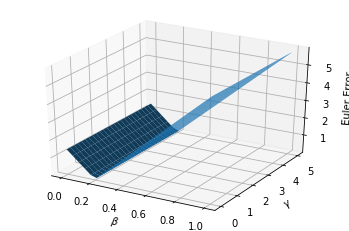

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z1,
                       linewidth=0,)

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
ax.set_zlabel('Euler Error')
plt.show()

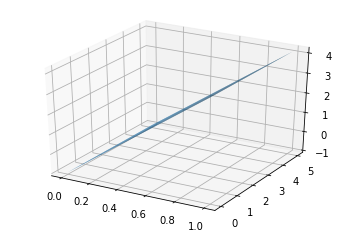

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z2,
                       linewidth=0,)
plt.show()